In [2]:
import covasim as cv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc
import datetime as dt
import matplotlib.ticker as ticker
from matplotlib import rc
#%config InlineBackend.figure_formats = ['svg']
rc('font', **{'family': 'serif', 'serif': ['Times']})
rc('text', usetex=False)
rc('grid', linestyle="--", color='black')

# original sims
ttq_sims = cv.load('../fig5_projections/fig5.msims')
# updated sims
abc_sims = cv.load('../fig5_projections/fig5-abc.msims')
# data
refsim = abc_sims[0].sims[0] # A reference simulation, any will do
xlims = refsim.day('2020-01-27', '2020-08-31')



tsfn = './kc_data/20200614chop5_KingCounty_Covasim_extended.xlsx' # Time series data
tsdf = pd.read_excel(tsfn, engine='openpyxl')
tsdf['date'] = pd.to_datetime(tsdf['date']).dt.date



Covasim 2.1.2 (2021-03-31) — © 2021 by IDM


/Users/davidogara/code/Covasim-Calibration/covasim-calibration/.covasim_calibration/lib/python3.10/site-packages/covasim/base.py:335: FutureWarning: sc.day() argument "start_day" has been deprecated as of v1.2.2; use "start_date" instead
  return sc.day(day, *args, start_day=self['start_day'])


/Users/davidogara/code/Covasim-Calibration/covasim-calibration/.covasim_calibration/lib/python3.10/site-packages/covasim/base.py:335: FutureWarning: sc.day() argument "start_day" has been deprecated as of v1.2.2; use "start_date" instead
  return sc.day(day, *args, start_day=self['start_day'])
/Users/davidogara/code/Covasim-Calibration/covasim-calibration/.covasim_calibration/lib/python3.10/site-packages/covasim/base.py:335: FutureWarning: sc.day() argument "start_day" has been deprecated as of v1.2.2; use "start_date" instead
  return sc.day(day, *args, start_day=self['start_day'])


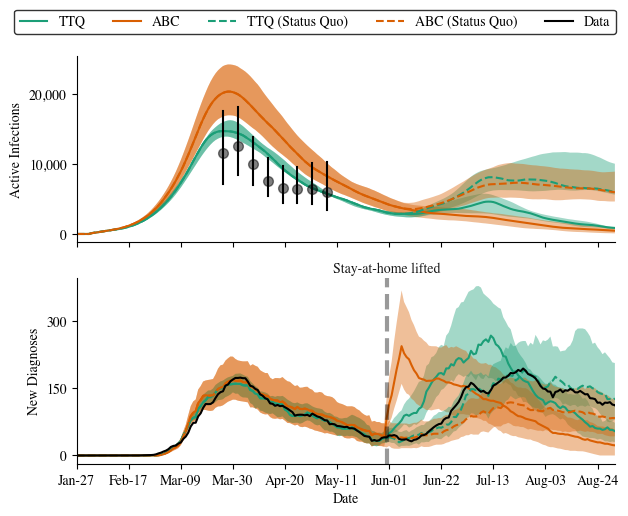

In [ ]:
from matplotlib.lines import Line2D
def roll(data):
    ''' Rolling window smoothing '''
    if hasattr(data, 'values'):
        data = data.values
    output = pd.Series(data).rolling(window=7).mean().fillna(0).values
    return output

@ticker.FuncFormatter
def date_formatter(x,pos):
        # print(x)
    return (refsim['start_day'] + dt.timedelta(days=x)).strftime('%b-%d')

fig, axs = plt.subplots(nrows=2,sharex=True)

colors = ['#1b9e77', '#d95f02']
outputs = ['n_infectious','new_diagnoses']

for i, key in enumerate(outputs):
    ax = axs[i]
    if True:
        # ttq
        res = ttq_sims['high'].results
        date = refsim.day(res['date']) # Convert to days
        best = res[key].values
        low  = res[key].low
        high = res[key].high
        ax.fill_between(date, roll(low), roll(high), facecolor=colors[0],alpha=0.4)
        ax.plot(date, roll(best), c=colors[0], alpha=1.0, label='TTQ')
        
        # ABC
        res = abc_sims['high'].results
        date = refsim.day(res['date']) # Convert to days
        best = res[key].values
        low  = res[key].low
        high = res[key].high
        ax.fill_between(date, roll(low), roll(high), facecolor=colors[1],alpha=0.4)
        ax.plot(date, roll(best), c=colors[1], alpha=1.0, label='ABC')

        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    if i>-1:
        # repeat for status quo
        # ttq
        res = ttq_sims['actual'].results
        date = refsim.day(res['date']) # Convert to days
        best = res[key].values
        low  = res[key].low
        high = res[key].high
        ax.fill_between(date, roll(low), roll(high), facecolor=colors[0],alpha=0.4)
        ax.plot(date, roll(best), c=colors[0], alpha=1.0, label='TTQ (Status Quo)',linestyle='dashed')

        # ABC
        res = abc_sims['actual'].results
        date = refsim.day(res['date']) # Convert to days
        best = res[key].values
        low  = res[key].low
        high = res[key].high
        ax.fill_between(date, roll(low), roll(high), facecolor=colors[1],alpha=0.4)
        ax.plot(date, roll(best), c=colors[1], alpha=1.0, label='ABC (Status Quo)',linestyle='dashed')

        
        ax.set_xlim(xlims)
        
        #ax.legend(frameon=True,edgecolor='black')
        day_stride = 21
        xmin,xmax = ax.get_xlim()
        ax.set_xticks(np.arange(xmin, xmax, day_stride))
        ax.xaxis.set_major_formatter(date_formatter)
        #ax.legend(frameon=True,edgecolor='black',loc='upper right',ncol=2)
        sc.boxoff(ax=ax)
    ax.set_ylabel(key.replace('_',' ').title())

# plot SCAN data
# prevalence data
if 'n_infectious' in outputs:
    pop_size = 2.25e6
    scan_file = '../inputs/scanprev_5_21.csv'
    scan = pd.read_csv(scan_file)
    for i,r in scan.iterrows():
        label = "Data" if i==0 else None
        ts = np.mean(refsim.day(r['since'], r['to']))
        low  = r['lower']*pop_size
        high = r['upper']*pop_size
        mean = r['mean']*pop_size
        axs[0].plot([ts]*2, [low, high], alpha=1.0, color='k', zorder=1000)
        axs[0].plot(ts, mean, 'o', markersize=7, color='k', alpha=0.5, label=label, zorder=1000)

# Date
ax = axs[1]
date = refsim.day(tsdf['date'].tolist())
ax.plot(date, roll(tsdf['new_diagnoses']), label='Data', color='black')
#ax.legend(frameon=True,edgecolor='black',loc='upper right',ncol=2)





# plot intervention
may31 = refsim.day('2020-05-31')
ax.axvline(may31, c='black', linestyle='--', alpha=0.4, lw=3)
yl = ax.get_ylim()
labely = yl[1]*1.03
ax.text(may31, labely, 'Stay-at-home lifted', color='black', alpha=0.9, style='italic', horizontalalignment='center')
ax.set_xlabel('Date')    

axs[1].set_ylabel('New Diagnoses')
axs[0].set_ylabel('Active Infections')
legend_colors = [colors[0],colors[1],colors[0],colors[1],'black']
legend_labels = ['TTQ','ABC','TTQ (Status Quo)','ABC (Status Quo)','Data']
legend_styles = [None,None,'dashed','dashed',None]


lines = []
for i in range(5):
    the_line = Line2D([0], [0], linestyle=legend_styles[i], color=legend_colors[i])
    lines.append(the_line)
fig.legend(
    lines,
    legend_labels,
    loc="lower center",
    bbox_to_anchor=(0.5,1.0),
    facecolor='white',
    ncol=5,
    edgecolor='black'
)
fig.tight_layout()

fig.savefig(
    '../hetGPy-calibration/figs/ttq-abc-policy-comparison.pdf',
    bbox_inches='tight'
    )

In [4]:
# compare diagnoses
def get_sim_results(sims):
    res = []
    for s in sims.sims:
        tmax = len(s.results['new_diagnoses'].values)
        df = pd.DataFrame(
            {'diagnoses' : roll(s.results['new_diagnoses'].values),
            'infectious': roll(s.results['n_infectious'].values),
            'diagnoses_data': roll(s.data['new_diagnoses'].values[0:tmax]),
            't': np.arange(0,tmax)
            }
        )
        df['rand_seed'] = s.pars['rand_seed']
        df['diagnoses_mae'] = np.abs(df['diagnoses'] - df['diagnoses_data'])
        res.append(df)
    return pd.concat(res)
abc_to_data = get_sim_results(abc_sims['actual'])
(abc_to_data
.query('t>133')
.groupby('rand_seed')
[['diagnoses','diagnoses_data']]
.corr().reset_index().query('diagnoses<1.0')
['diagnoses'].describe()
)

count    50.000000
mean      0.821453
std       0.090495
min       0.578930
25%       0.791355
50%       0.840678
75%       0.881550
max       0.934593
Name: diagnoses, dtype: float64

In [5]:
# error measure
abc_to_data.query('t>133').groupby('rand_seed')['diagnoses_mae'].mean().describe()

count    50.000000
mean     43.796161
std      16.998115
min      13.911565
25%      29.137755
50%      44.175170
75%      56.908163
max      83.095238
Name: diagnoses_mae, dtype: float64

In [6]:
ttq_to_data = get_sim_results(ttq_sims['actual'])
(ttq_to_data
.query('t>133')
.groupby('rand_seed')
[['diagnoses','diagnoses_data']]
.corr().reset_index().query('diagnoses<1.0')
['diagnoses'].describe()
)

count    5.000000
mean     0.851652
std      0.070042
min      0.784421
25%      0.804850
50%      0.816742
75%      0.908766
max      0.943480
Name: diagnoses, dtype: float64

In [7]:
# error measure
ttq_to_data.query('t>133').groupby('rand_seed')['diagnoses_mae'].mean().describe()

count     5.000000
mean     36.820100
std      24.540767
min      11.148213
25%      19.530351
50%      37.308914
75%      41.491387
max      74.621634
Name: diagnoses_mae, dtype: float64

In [15]:
from scipy.stats import ttest_ind

a = (abc_to_data
.query('t>133')
.groupby('rand_seed')
[['diagnoses','diagnoses_data']]
.corr().reset_index().query('diagnoses<1.0')
['diagnoses'].values)
b = (ttq_to_data
.query('t>133')
.groupby('rand_seed')
[['diagnoses','diagnoses_data']]
.corr().reset_index().query('diagnoses<1.0')
['diagnoses'].values)
ttest_ind(a,b,equal_var=False)


TtestResult(statistic=-0.8924672923174298, pvalue=0.4099164713855285, df=5.434529303239188)

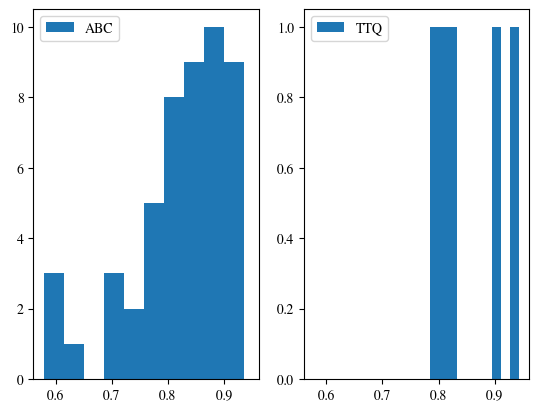

In [14]:
fig, ax = plt.subplots(ncols=2,sharex=True)
ax[0].hist(a,label='ABC')
ax[1].hist(b,label='TTQ')
[a.legend() for a in ax]
plt.show()

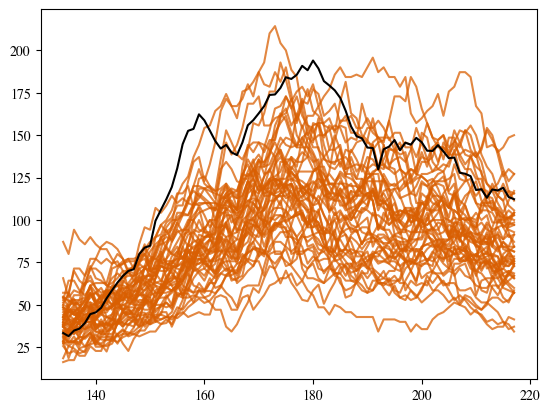

In [9]:
fig, ax = plt.subplots()
for i,rand_seed in enumerate(abc_to_data['rand_seed'].unique()):
    d = abc_to_data.query('rand_seed==@rand_seed and t>133')
    ax.plot(d.t,d.diagnoses,color=colors[1],alpha=0.75,zorder=10)
    if i==0:
        ax.plot(d.t,d.diagnoses_data,color='black',label='Data',zorder=1000)

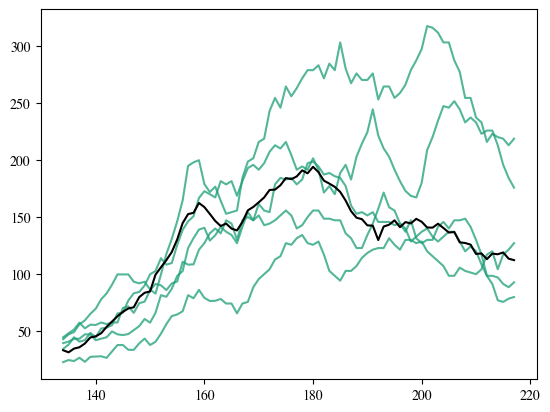

In [10]:
fig, ax = plt.subplots()
for i,rand_seed in enumerate(ttq_to_data['rand_seed'].unique()):
    d = ttq_to_data.query('rand_seed==@rand_seed and t>133')
    ax.plot(d.t,d.diagnoses,color=colors[0],alpha=0.75,zorder=10)
    if i==0:
        ax.plot(d.t,d.diagnoses_data,color='black',label='Data',zorder=1000)

In [11]:
attack_rate = []
for s in abc_sims['actual'].sims:
    attack_rate.append(s.results['cum_infections'].values[-1]/2.25e6)
pd.DataFrame({'attack_rate':attack_rate}).describe()

,attack_rate
count,50.000000
mean,0.082679
std,0.010436
min,0.058337
25%,0.075615
50%,0.081914
75%,0.090183
max,0.103049


In [12]:
s.results['cum_infections'].values

array([   300.        ,    300.        ,    312.        ,    351.        ,
          416.        ,    486.        ,    583.        ,    665.        ,
          766.        ,    866.        ,    996.        ,   1125.        ,
         1282.        ,   1410.        ,   1590.        ,   1773.        ,
         2012.        ,   2241.        ,   2488.        ,   2767.        ,
         3099.        ,   3438.        ,   3842.        ,   4257.        ,
         4718.        ,   5235.        ,   5846.        ,   6501.        ,
         7228.        ,   8005.        ,   8866.        ,   9704.        ,
        10691.        ,  11722.        ,  12882.5       ,  14087.66      ,
        15422.653     ,  16867.7197    ,  18400.92522   ,  20080.365048  ,
        21859.5437603 ,  23549.081486  ,  25501.89089191,  27612.25407536,
        29666.49810375,  31814.89498346,  33971.85121327,  36190.72007562,
        38472.67134833,  40405.94322839,  42502.16230977,  44617.36888283,
        46760.29719374,  

In [13]:
# stats for paper

# compare 

